In [21]:
import cv2
import calendar
import os
from pathlib import Path
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt


In [9]:
def read_meta(meta_path):
    """Load latitude and longitude vectors in degrees."""
    # meta = np.fromfile(os.path.join(meta_path, 'T000gri.META'),
    #    dtype=np.float32)
    lons = np.fromfile(
        os.path.join(meta_path, "T000gri.LONvec"), dtype=np.float32
    )
    lats = np.fromfile(
        os.path.join(meta_path, "T000gri.LATvec"), dtype=np.float32
    )
    lats = np.flipud(lats)  # reverse. now from -18 to -43
    # ly, lx = LATdeg_vec.size, LONdeg_vec.size
    return lats, lons

lats, lons = read_meta("../datasets/les_server/meta/")
print(f"lats.shape: {lats.shape}, lons.shape: {lons.shape}")

lats_np = np.load("../datasets/les_server/meta/lats.npy")
lons_np = np.load("../datasets/les_server/meta/lons.npy")
print(f"lats_np.shape: {lats_np.shape}, lons_np.shape: {lons_np.shape}")

print(f"lats are equal: {np.all(lats == lats_np)}")
print(f"lons are equal: {np.all(lons == lons_np)}")



lats.shape: (2501,), lons.shape: (3001,)
lats_np.shape: (2501,), lons_np.shape: (3001,)
lats are equal: True
lons are equal: True


In [12]:
def get_dtime(img_name):
    """Assume img_name is 'ART_yyyydoy_hhmmss.FR' """
    yyyydoy, hhmmss = (
        img_name.split("_")[1],
        img_name.split("_")[2][:6],
    )
    year, doy = int(yyyydoy[:4]), int(yyyydoy[4:])
    hs, mins, sec = (
        int(hhmmss[:2]),
        int(hhmmss[2:4]),
        int(hhmmss[4:]),
    )
    dtime = dt.datetime(
        year,
        1,
        1,
        hour=hs,
        minute=mins,
        second=sec,
        tzinfo=dt.timezone.utc,
    ) + dt.timedelta(doy - 1)
    return dtime

dtime = get_dtime("ART_2024001_100020.FR")
print(f"dtime: {dtime}")


dtime: 2024-01-01 10:00:20+00:00


In [17]:
def daily_solar_angles(year, doy):
    days_year = calendar.isleap(year) * 1 + 365
    gamma_rad = 2 * np.pi * (doy - 1) / days_year
    delta_rad = (
        0.006918
        - 0.399912 * np.cos(gamma_rad)
        + 0.070257 * np.sin(gamma_rad)
        - 0.006758 * np.cos(2 * gamma_rad)
        + 0.000907 * np.sin(2 * gamma_rad)
        - 0.002697 * np.cos(3 * gamma_rad)
        + 0.00148 * np.sin(3 * gamma_rad)
    )
    eot_min = (
        60
        * 3.8196667
        * (
            0.000075
            + 0.001868 * np.cos(gamma_rad)
            - 0.032077 * np.sin(gamma_rad)
            - 0.014615 * np.cos(2 * gamma_rad)
            - 0.040849 * np.sin(2 * gamma_rad)
        )
    )
    return delta_rad, eot_min

def solar_angles(
    lat, lon, delta_rad, eot_min, hour, minute, second, ret_mask=True
):
    lat_rad = lat * np.pi / 180
    h_sol = (
        hour + minute / 60 + lon / 15 + eot_min / 60 + second / 3600
    )
    w_rad = np.pi * (h_sol / 12 - 1)
    cos_zenith = np.sin(lat_rad) * np.sin(delta_rad) + np.cos(
        lat_rad
    ) * np.cos(delta_rad) * np.cos(w_rad)
    mask = cos_zenith > 0
    if cos_zenith.size > 1:
        cos_zenith[~mask] = 0
    elif cos_zenith.size == 1:
        cos_zenith = cos_zenith * mask
    if ret_mask:
        return cos_zenith, mask
    else:
        return cos_zenith

def get_doy(dtime):
    """Return day of year from datetime.
    From "https://stackoverflow.com/questions/
    620305/convert-year-month-day-to-day-
    of-year-in-python"."""
    return dtime.timetuple().tm_yday

def get_cosangs(dtime, lats, lons):
    """Combine the two solar angle functions"""
    delta_rad, eot_min = daily_solar_angles(
        dtime.year, get_doy(dtime)
    )
    cosangs, cos_mask = solar_angles(
        lats[:, np.newaxis],
        lons[np.newaxis, :],
        delta_rad,
        eot_min,
        dtime.hour,
        dtime.minute,
        dtime.second,
    )
    return cosangs, cos_mask


cosangs, cos_mask = get_cosangs(dtime, lats, lons)
print(f"cosnags.shape: {cosangs.shape}, cos_mask.shape: {cos_mask.shape}")
print(f"cosangs.min: {cosangs.min()}, cosangs.max: {cosangs.max()}")


cosnags.shape: (2501, 3001), cos_mask.shape: (2501, 3001)
cosangs.min: 0.0, cosangs.max: 0.45663270354270935


In [19]:
def load_mask(img_name, mk_folder_path, ly, lx):
    MK2 = np.fromfile(
        os.path.join(mk_folder_path, img_name.split(".")[0] + ".MK"),
        dtype=np.int16,
    )
    MK2 = MK2.reshape(ly, lx)
    img_mask = (~MK2 + 2).astype(
        np.uint8
    )  # adapt to cv2.inpaint format
    return img_mask


img_mask = load_mask(
    "ART_2024001_100020.FR", "../datasets/les_server/C02-MK/", lats.size, lons.size
)
print(f"img_mask.shape: {img_mask.shape}")
print(f"np.unique(img_mask): {np.unique(img_mask)}")


img_mask.shape: (2501, 3001)
np.unique(img_mask): [0 1]


img.shape: (2501, 3001)
img.min: 0.007936500012874603, img.max: 62.37031173706055
rp_img.min: 0.0, ro_img.max: 304.04705810546875


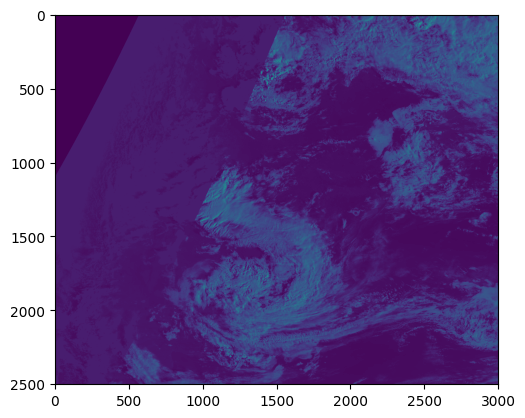

In [25]:
def load_img(img_name, img_folder_path, ly, lx, datatype=np.float32):
    img = np.fromfile(
        os.path.join(img_folder_path, img_name), dtype=datatype
    )
    img = img.reshape(ly, lx)
    return img

def normalize(img, cosangs, thresh):
    """Normalization involves dividing by cosangs if greater
  than 0, and clipping if cosangs is below threshold"""
    n1 = np.divide(
        img, cosangs, out=np.zeros_like(img), where=thresh < cosangs
    )
    n2 = np.divide(
        img,
        cosangs,
        out=np.zeros_like(img),
        where=(0 < cosangs) * (cosangs <= thresh),
    )
    return n1 + np.clip(n2, 0, np.nanmean(n1)) #np.amax(n1))


img = load_img(
    "ART_2024001_100020.FR", "../datasets/les_server/C02-FR/", lats.size, lons.size
)

rp_image = normalize(img, cosangs, 0.15)

print(f"img.shape: {img.shape}")
print(f"img.min: {img.min()}, img.max: {img.max()}")
print(f"rp_img.min: {rp_image.min()}, ro_img.max: {rp_image.max()}")

plt.imshow(rp_image, cmap='viridis')
plt.show()


## Get crop of Salto to compare

lats[pixel_i]: -31.389999389648438
lats range: -26.270000457763672 - -36.5099983215332
lons[pixel_j]: -57.95000076293945
lons range: -63.06999969482422 - -52.83000183105469


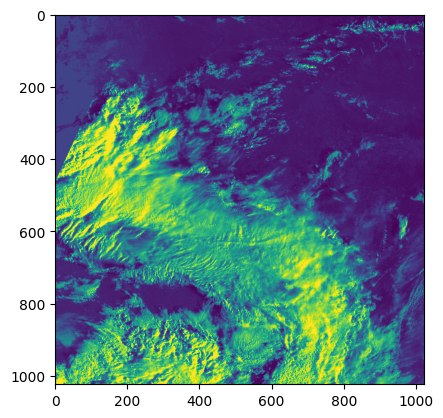

In [30]:
def get_pixel2(loc, img, size, lats, lons):
    """Gets target pixel value"""
    i = find_nearest_index(lats, loc["lat"])
    j = find_nearest_index(lons, loc["lon"])
    target = img[i - size//2: i + size//2, j - size//2: j + size//2]
    return target, i, j


def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

loc = {
    "lat": -31.390502,
    "lon": -57.954138,  # Salto, Uruguay
}

crop_img, pixel_i, pixel_j = get_pixel2(loc, rp_image, 1024, lats, lons)
crop_img = np.clip(crop_img, 0, 100)

print(f"lats[pixel_i]: {lats[pixel_i]}")
print(f"lats range: {lats[pixel_i - 1024//2]} - {lats[pixel_i + 1024//2]}")

print(f"lons[pixel_j]: {lons[pixel_j]}")
print(f"lons range: {lons[pixel_j - 1024//2]} - {lons[pixel_j + 1024//2]}")

plt.imshow(crop_img, cmap='viridis')
plt.show()


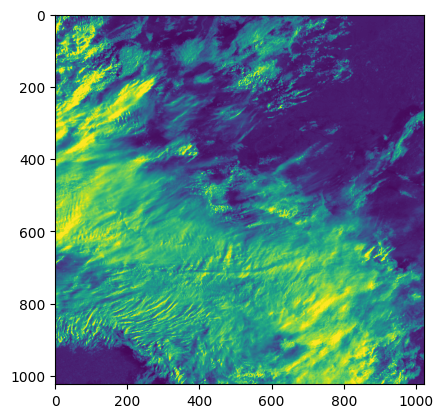

In [27]:
crop_dataset = np.load("../datasets/les_server/2024_001_UTC_100020.npy")

plt.imshow(crop_dataset, cmap='viridis')
plt.show()